# NYC SAT Score by School vs Crime Density
Note: must import packages (pandas, numpy, matplotlib, scipy, shapely, geopy, sklearn) 
## Feature Engineering

### Loading School Data into Pandas Dataframes and Cleaning
2014 SAT raw data
- reading the 2014 data in from the raw csv data
- renaming the columns of the dataframe to simplified values
- dropping the columns that don't have entries for the SAT scores (i.e null values for any Math, Writing, Reading column (testing columns))
- creating Total column which sums the 3 scoring areas (Math, Writing, Reading)

2012 SAT raw data
- reading the 2012 data in from the raw csv data
- renaming the columns of the dataframe to simplified values
- dropping the columns which have invalid entries for the SAT scores (i.e values for testing columns equal to 's')
- creating Total column which sums the 3 scoring areas (Math, Writing, Reading)
- creating columns for Longitude and Latitude because 2012 raw data did not have these columns
- taking intersect of dataframes' DBNs for the purpose of mapping respective longitudes and latitudes

2012 and 2014 SAT cleaning
- removing entries not in the intersection of DBNs
- mapping longitude and latitude from 2014 data to 2012 data by DBN unique identifier
- exporting cleaned data to new csv files

In [1]:
import pandas as pd
import numpy as np

df2014r = pd.read_csv('2014.csv', usecols = [0, 8, 9, 18, 19, 20])
df2014r.columns = ['DBN', 'Latitude', 'Longitude', 'Math', 'Reading', 'Writing']
df2014c = df2014r.drop(df2014r.loc[pd.isnull(df2014r['Math']) == True].index)
df2014c['Total'] = 0
df2014c['Total'] = df2014c[['Math', 'Reading', 'Writing']].astype(int).sum(axis=1)

df2012r = pd.read_csv('2012.csv', usecols = [0, 3, 4, 5]);
df2012r.columns = ['DBN', 'Reading', 'Math', 'Writing']
df2012c = df2012r.drop(df2012r.loc[df2012r['Math'] == 's'].index)
df2012c['Total'] = 0
df2012c['Total'] = df2012c[['Math', 'Reading', 'Writing']].astype(int).sum(axis=1)
df2012c['Longitude'] = 0.0
df2012c['Latitude'] = 0.0
DBNintersect = np.intersect1d(df2012c['DBN'].values, df2014c['DBN'].values)
df2012c = df2012c[df2012c['DBN'].isin(DBNintersect)]
df2014c = df2014c[df2014c['DBN'].isin(DBNintersect)]
df2012c = df2012c.sort_values('DBN')
df2014c = df2014c.sort_values('DBN')
df2012c['Latitude'] = df2014c['Latitude'].values
df2012c['Longitude'] = df2014c['Longitude'].values

df2012c.to_csv('2012c.csv', index = False)
df2014c.to_csv('2014c.csv', index = False)

### Loading the Crime Data into DataFrames and Cleaning

- reading the raw crime data into a dataframe
- renaming the columns of the dataframe to simplified values
- dropping entries which don't have location entries (i.e null enties for longitude or latitude)
- cutting datetime format to year format
- dropping the entries corresponding to years neither 2012 nor 2014 because that is the data we have for the SAT scores
- exporting cleaned data to new csv file
- exporting unique crime complaint types to csv to be used to find which are violent

In [2]:
dfCrime = pd.read_csv('Crime.csv', usecols = [5, 7, 21, 22])
dfCrime.columns = ['Date', 'Crime Type', 'Latitude', 'Longitude']
dfCrime = dfCrime.drop(dfCrime.loc[pd.isnull(dfCrime['Longitude']) == True].index)
dfCrime = dfCrime.drop(dfCrime.loc[pd.isnull(dfCrime['Latitude']) == True].index)
dfCrime['Date'] = dfCrime['Date'].str[-4:]
dfCrime = dfCrime.drop(dfCrime.loc[(dfCrime['Date'] != '2012') & (dfCrime['Date'] != '2014')].index)
dfCrime.to_csv('Crimec.csv', index = False)

uniqueCrime = pd.Series(list(set(list(dfCrime['Crime Type']))))
uniqueCrime.to_csv('Unique Crimes.csv')

### Classifying each Crime Complaint to the Closest School (KNN with N = 1 where DBN is Classifier)

- creating dictionary which maps DBN of school to number of crimes in proximity
- intitializing dictionary to have zero crimes in proximity for the values
- dropping all entries which are not 2012 (i.e 2014 entries)
- grabbing longitude and latitude coordinates from the entries of schools
- generating list of DBNs which correspond with the list of coordinates
- iterating through crime complaint entries to obtain their locations
- creating list of distances from crime complaint location to school location to populate
- iterating through coordinates to find closest school to complaint location
- populating the list of distances with distance from complaint to school
- calculating minimum distance between the complaint and the respective school
- adding to the crime count for the school DBN that has the minimum distance
- converting populated dictionary to dataframe and exporting to csv

In [54]:
import geopy.distance
from IPython.display import clear_output

DBNtoCrime = {}
for index, school in df2012c.iterrows():
    DBNtoCrime[school['DBN']] = 0

dfCrime2012 = dfCrime.drop(dfCrime.loc[(dfCrime['Date'] != '2012')].index)
subsetCrime2012indices = np.random.uniform(low = 0, high = (len(dfCrime2012) - 1), size = 50000).astype(int)
subsetCrime2012 = dfCrime2012.iloc[subsetCrime2012indices]

coords = list(zip(df2012c['Longitude'], df2012c['Latitude']))
DBNs = list(df2012c['DBN'])

i = 0
print(str((int) (i / len(subsetCrime2012indices))) + "% done")
for index, crime in subsetCrime2012.iterrows():
    distances = list()
    for coord in coords:
        distances.append(geopy.distance.vincenty(coord, (crime['Longitude'], crime['Latitude'])))
    coordIndex = distances.index(min(distances))
    DBNtoCrime[DBNs[coordIndex]] = DBNtoCrime[DBNs[coordIndex]] + 1
    i += 1
    if i % 100 is 0:
        clear_output()
        print(str((i / len(subsetCrime2012indices) * 100)) + "% done")

100.0% done


In [55]:
dfCrime2012c = pd.DataFrame(DBNtoCrime, index = [range(0,len(DBNtoCrime.keys()))]).T
dfCrime2012c.columns = ['Num Crimes']
dfCrime2012c.to_csv('batch4.csv')

### Combining the 4 Generated Sample Sets for Regression

- reading the sample batches into DataFrames
- combinging the samples into one DataFrame to be used as training data

In [3]:
df1 = pd.read_csv('batch1.csv')
df1.columns = ['DBN', 'Crimes']
df2 = pd.read_csv('batch2.csv')
df2.columns = ['DBN', 'Crimes']
df3 = pd.read_csv('batch3.csv')
df3.columns = ['DBN', 'Crimes']
df4 = pd.read_csv('batch4.csv')
df4.columns = ['DBN', 'Crimes']
trainingCrime = pd.concat([df1['DBN'], df1['Crimes'], df2['Crimes'], df3['Crimes'], df4['Crimes']], axis = 1, keys = ['DBN', 'S1', 'S2', 'S3', 'S4'])
trainingCrime.columns = ['DBN', 'S1', 'S2', 'S3', 'S4']

### Cleaning Datasets to Enforce Compatibility

- dropping columns that have no crimes committed in proximity because will result in an outlier
- taking the intersecting of the DBNs and dropping entries from each not in the intersection
- outputting the finalized training data to csv files
- cleaning the testing sample and outputing it to a csv

In [4]:
trainingCrime = trainingCrime.drop(trainingCrime.loc[trainingCrime['S1'] == 0].index)
trainingCrime.to_csv('TrainingCrime.csv', index = False)
trainingSAT = df2012c
trainingSAT = trainingSAT.drop(labels = ['Longitude', 'Latitude'], axis = 'columns')
DBNintersect = np.intersect1d(df2012c['DBN'].values, trainingCrime['DBN'].values)
trainingCrime = trainingCrime[trainingCrime['DBN'].isin(DBNintersect)]
trainingSAT = trainingSAT[trainingSAT['DBN'].isin(DBNintersect)]
trainingCrime.to_csv('TrainingCrime.csv', index = False)
trainingSAT.to_csv('TrainingSAT.csv', index = False)

df4 = pd.read_csv('batch5.csv')
df4.columns = ['DBN', 'Crimes']
testingData = df4[df4['DBN'].isin(DBNintersect)]
testingData.to_csv('TestingData.csv')

## Graphing
### Plotting Regression Model on Training Data

Creating figure and plotting all of the X-Y pairs from the 4 different samples

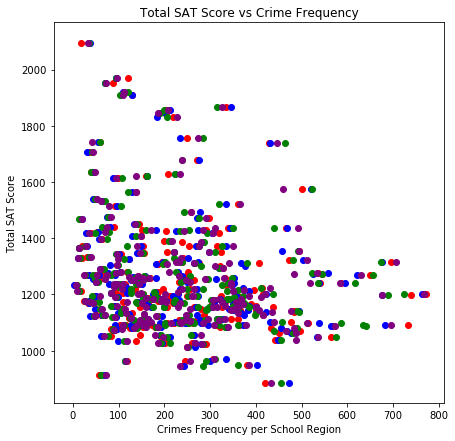

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import datasets, linear_model

plt.figure(figsize=(7,7))
x1 = trainingCrime['S1'].T
x2 = trainingCrime['S2'].T
x3 = trainingCrime['S3'].T
x4 = trainingCrime['S4'].T
y = trainingSAT['Total'].T
plt.scatter(x1, y,  color='red')
plt.scatter(x2, y,  color='blue')
plt.scatter(x3, y,  color='green')
plt.scatter(x4, y,  color='purple')
plt.ylabel('Total SAT Score')
plt.xlabel('Crimes Frequency per School Region')
plt.title('Total SAT Score vs Crime Frequency')
plt.savefig('Scatter.png')
plt.show()

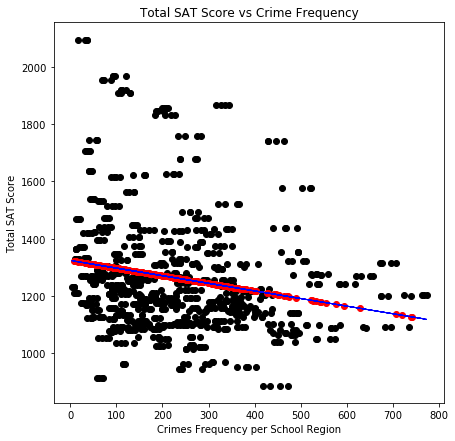

Mean Error: 152.698519616
Mean Percentage Error: 0.117071637074
Mean Error: 45598.0720716


In [28]:
from sklearn import linear_model

plt.figure(figsize=(7,7))
x1 = (trainingCrime['S1']).T
x2 = (trainingCrime['S2']).T
x3 = (trainingCrime['S3']).T
x4 = (trainingCrime['S4']).T
test = testingData['Crimes']
test = test.values.reshape(len(test), 1)
y = (trainingSAT['Total']).T

X = (x1.append(x2).append(x3).append(x4))
X = X.values.reshape(len(X), 1)
Y = (y.append(y).append(y).append(y))
Y = Y.values.reshape(len(Y), 1)

plt.scatter(X, Y,  color='black')
regr = linear_model.LinearRegression()
regr.fit(X, Y)
plt.plot(X, regr.predict(X), color='blue',linewidth=1)
plt.scatter(test, regr.predict(test), color='red')

plt.ylabel('Total SAT Score')
plt.xlabel('Crimes Frequency per School Region')
plt.title('Total SAT Score vs Crime Frequency')
plt.savefig('Regression.png')
plt.show()

testY = regr.predict(test)
predicted = np.repeat(testY, 4)
sum = 0
for i in range(0, len(Y)):
    sum += np.abs(Y[i] - predicted[i])
meanError = sum / (len(Y))
sum = 0
for i in range(0, len(Y)):
    sum += np.abs(Y[i] - predicted[i]) / Y[i]
meanPercentageError = sum / (len(Y))
mse = np.mean((Y - predicted)**2)
print("Mean Error: " + str(meanError[0]))
print("Mean Percentage Error: " + str(meanPercentageError[0]))
print("Mean Error: " + str(mse))

### Creating regions acting as school districts

- creating list of coordinates for the schools
- extracting lists of longitudes and latitudes to be used as x and y in scatterplot
- creating Voronoi diagram model from the list of coordinates

In [12]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point, Polygon

coords = list(zip(df2012c['Longitude'], df2012c['Latitude']))
long, lat = zip(*coords)
vor = Voronoi(coords)

### Creating Voronoi Figure with Schools Overlaid

- creating figure and setting size for exporting
- adding polygon regions that are not null (i.e not -1)
- scaling the ranges of the figure for better visualization
- plotting the locations of the schools over the regions to show that most regions represent the schools, and note that some of the school lay outside a region, i.e correspond to the null regions
- saving the picture of the figure and displaying it in notebook

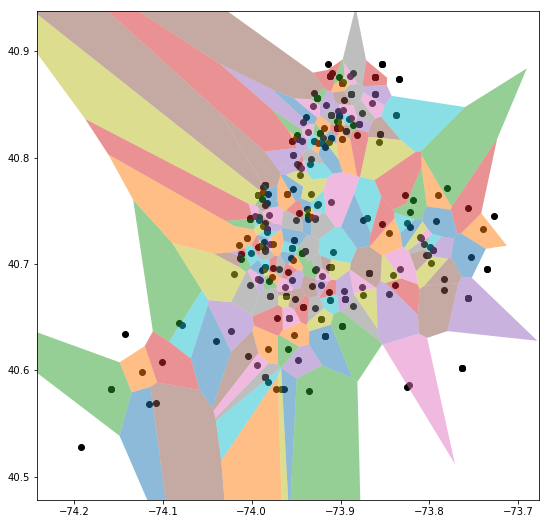

In [127]:
plt.figure(figsize=(9,9))
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .5)
plt.xlim(vor.min_bound[0] - 0.05, vor.max_bound[0] + 0.05)
plt.ylim(vor.min_bound[1] - 0.05, vor.max_bound[1] + 0.05)
plt.scatter(long, lat, c = 'black')
plt.savefig('Regions.png')
plt.show()

### Function for Area of Polygon for School Districts

In [17]:
# function retieved from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area